In [1]:
%matplotlib inline

import numpy as np
from scipy.io import loadmat
import matplotlib.pylab as plt
import re
from glob import glob
import pandas as pd
import sys
from statsmodels.formula.api import ols
import statsmodels.stats.anova as statsAnova
from IPython.display import clear_output
import seaborn as sns

convertedSubjects = ["622", "623", "624", "628", "636", "637", "646", "647", "649", "651", "652", "653"]
nbScout = 90
conditions = ["Face_Averted", "Face_Direct", "Noise", "Shift_Averted", "Shift_Direct"]
path = 'E:/brainstorm_db/AutismMayada/data/'

In [2]:
# Utilitary function to extract connectivity information from Brainstorm connectivity files
def getConnMatrix(mat):
        
    N = max(mat["RefRowNames"].shape)    
    M = max(mat["RowNames"].shape)    
    assert(N==M)

    a = np.zeros((N, N), dtype=np.complex)
    indLow = np.tril_indices(N, 0, M)
    a[indLow] = mat["TF"][:, 0]
    
    dia = np.diag(np.diagonal(np.abs(a)))
    a = np.abs(np.flipud(np.rot90(a)))+ np.abs(a)-2*dia

    print(N, M, a.shape)
    return np.reshape(a, (a.shape[0], a.shape[1], 1))

Getting the statistics for number of epochs available
=========================

In [3]:
subjects   = []
epochConditions = []
groups = []
for fileName in glob(path + '*/*/data_*_notch_montage.mat'): 
    condition = [c for c in conditions if c in fileName][0]
    epochConditions.append(condition)
    subject = re.search(r'\d{3}', fileName).group(0)
    subjects.append(subject)
    group = subject[0]
    if subject in convertedSubjects:
        group = "5"
    groups.append(group)

0                    
                       mean        std min  max
epochConditions                                
Face_Averted      31.893333  10.217332  10   70
Face_Direct       31.893333  10.134999  10   70
Noise             44.533333  14.133852   9   94
Shift_Averted    126.586667  40.783573  41  283
Shift_Direct     127.040000  40.507403  37  278

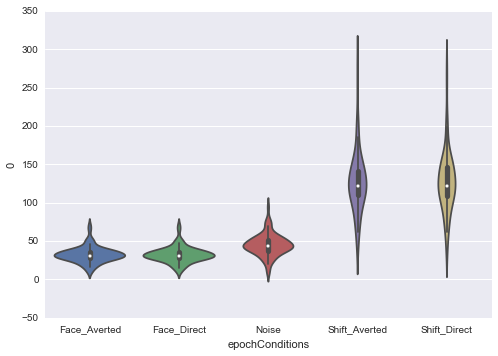

In [4]:
datSubject = {"subject":subjects, "epochConditions":epochConditions}
df = pd.DataFrame(datSubject).groupby(["subject", "epochConditions"]).size().reset_index() #agg('count')
sns.violinplot(x="epochConditions", y=0, data=pd.DataFrame(df))
pd.DataFrame(df).groupby("epochConditions").agg(["mean", "std", "min", "max"])

Showing that there is not big between-group differences in sample/subject
=========

In [5]:
datSubject = {"subject":subjects, "epochConditions":epochConditions, "groups":groups}
df = pd.DataFrame(datSubject).groupby(["subject", "epochConditions", "groups"]).size().reset_index() #agg('count')
pd.DataFrame(df).groupby(["epochConditions", "groups"]).agg(["mean", "std", "min", "max"])

0                    
                              mean        std min  max
epochConditions groups                                
Face_Averted    5        31.545455  10.395803  17   52
                6        31.333333   9.972426  10   64
                7        32.325000  10.549973  10   70
Face_Direct     5        32.181818  10.176622  18   52
                6        31.250000   9.883011  11   64
                7        32.200000  10.505676  10   70
Noise           5        47.181818  15.124934  26   76
                6        44.708333  14.783890  11   94
                7        43.700000  13.739705   9   75
Shift_Averted   5       126.000000  43.067389  70  206
                6       123.833333  38.566337  41  249
                7       128.400000  42.368832  42  283
Shift_Direct    5       128.090909  43.452168  70  206
                6       125.041667  39.048998  43  251
                7       127.950000  41.550062  37  278

In [6]:
rowNames = []
results={}

files   = glob(path + '*/*/timefreq_connectn_plv_*.mat')
nbFiles = len(files)
subjects   = []
epochConditions = []
groups     = [] 
for i, conFileName in enumerate(files): 

    mat = loadmat(conFileName)
    if len(mat["RowNames"])  == nbScout:      
        rowNames = mat["RowNames"]
        dataFile = mat["DataFile"][0]
        condition = [c for c in conditions if c in dataFile][0]
        epochConditions.append(condition)
        subject = re.search(r'\d{3}', dataFile).group(0)
        subjects.append(subject)
        group = subject[0]
        if subject in convertedSubjects:
            group = "5"
        groups.append(group)
        band = mat["Freqs"][0][1][0]
        bandMat = getConnMatrix(mat)
        if (group, condition, band) in results:
            results[(group, condition, band)] = np.concatenate((results[(group, condition, band)], bandMat), axis=2)
        else:
            results[(group, condition, band)] = bandMat

    clear_output()
    print(i, '/', len(files)-1) #N-1)
    sys.stdout.flush()
    
rowNames = [rowName[0][0] for rowName in rowNames]   

2224 / 2224


In [7]:
datSubject = {"subject":subjects, "groups":[int(g) for g in groups]}
groupsSizeDat = pd.DataFrame(datSubject).groupby("subject").median()
print("N for HRA-ASD:", sum(groupsSizeDat["groups"] == 5))
print("N for HRA-noASD:", sum(groupsSizeDat["groups"] == 6))
print("N for Controls:", sum(groupsSizeDat["groups"] == 7))

N for HRA-ASD: 11
N for HRA-noASD: 24
N for Controls: 40


In [8]:
bands = np.unique([key[2] for key in results.keys()])
print("Bands:")
for band in bands:
    print(band)

Bands:
1, 4
12, 16
16, 30
30, 100
4, 8
8, 12


Generating the violin plot figure
==========================

In [9]:
import pandas as pd
dataReg2 = {"con":[], "group":[], "region":[], "condition":[], "band":[]} 
for condition in conditions:               
    for band in bands:
        for group in ("5", "6", "7"):
            data = results[(group, condition, band)]
            cons = np.median(data, axis=1)
            nbReg, nbSub = cons.shape
            dataReg2["con"].extend(cons.flatten())
            dataReg2["region"].extend(rowNames*nbSub)
            dataReg2["group"].extend([group]*nbReg*nbSub)
            dataReg2["condition"].extend([condition]*nbReg*nbSub)
            dataReg2["band"].extend([band]*nbReg*nbSub)

dataReg2 = pd.DataFrame(dataReg2)


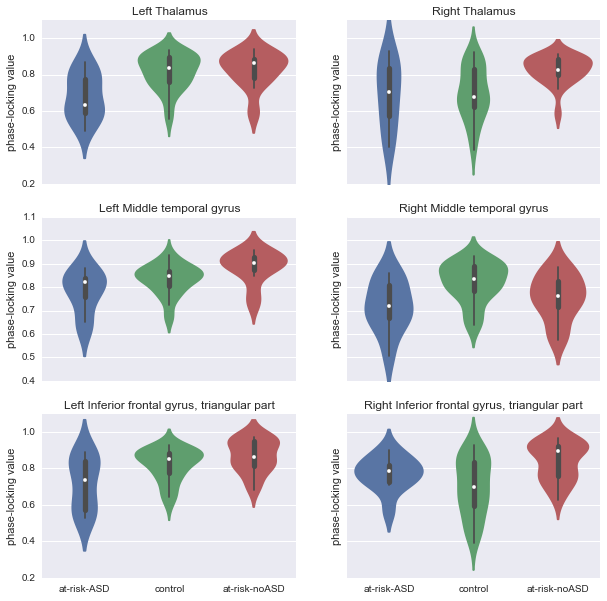

In [24]:
condition = 'Face_Direct'
lats = ['Left', 'Right']
plotRegions = ["Thalamus", "Middle temporal gyrus", "Inferior frontal gyrus, triangular part"]
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['figure.dpi'] = 300
f, axes = plt.subplots(len(plotRegions), len(lats), sharex='col', sharey='row')
band = '1, 4'

ymin = [0.2, 0.4, 0.2]
ymax = [1.1, 1.1, 1.1]
for i, region_part in enumerate(plotRegions):
    for j, lat in enumerate(lats):
        region = lat + " " + region_part
        dataTmp = dataReg2[(dataReg2["band"]==band) & 
                                    (dataReg2["condition"]==condition) &
                                    (dataReg2["region"] == region)]    
    
        while(1):
            rmodel = ols(formula = 'con ~ group', data=dataTmp).fit()
            test = rmodel.outlier_test()
            outliers = [(dataTmp.irow(i)["con"], dataTmp.irow(i)["group"]) 
                                    for i,t in enumerate(test.icol(2)) if t < 0.5]
            if len(outliers) == 0:
                break
            for con_outlier, group_outlier in outliers:
                dataTmp = dataTmp[np.logical_not((dataTmp.group == group_outlier) & 
                                                 (dataTmp.con == con_outlier))]
        
        
        ax = axes[i, j]
        sns.violinplot(x="group", y="con",
                       data=dataTmp, order=["5", "7", "6"],
                       ax=ax)
        ax.set_title(region)
        ax.set_ylim(ymin[i], ymax[i])
        ax.set_xticklabels(["at-risk-ASD", "control", "at-risk-noASD"])
        ax.set_ylabel("phase-locking value")
        ax.set_xlabel("")
        
f.savefig('C:/Users/Orechr/Dropbox/Publications (current)/Conferences/IMFAR 2016/connectivity.svg', dpi=300)

Generate the tables
======================

In [10]:
def generateTables(group1, group2, condition = 'Face_Direct', band = '1, 4'):

    condition = 'Face_Direct'
    band      = '1, 4'
    pvalues = []
    tvalues = []
    mean1 = []
    mean2 = []
    std1 = []
    std2 = []
    for region in rowNames:
        dataTmp = dataReg2[(dataReg2["band"]==band) & 
                            (dataReg2["condition"]==condition) &
                            (dataReg2["region"]==region) &
                            np.in1d(dataReg2["group"], [group1, group2])]

        while(1):
            rmodel = ols(formula = 'con ~ group', data=dataTmp).fit()
            test = rmodel.outlier_test()
            outliers = [(dataTmp.irow(i)["con"], dataTmp.irow(i)["group"]) 
                                    for i,t in enumerate(test.icol(2)) if t < 0.5]
            if len(outliers) == 0:
                break
            for con_outlier, group_outlier in outliers:
                dataTmp = dataTmp[np.logical_not((dataTmp.group == group_outlier) & 
                                                 (dataTmp.con == con_outlier))]



        pvalues.append(statsAnova.anova_lm(rmodel, typ=2)["PR(>F)"][0])
        tvalues.append(rmodel.tvalues[1])
        mean1.append(dataTmp.groupby("group").mean()["con"][0])
        mean2.append(dataTmp.groupby("group").mean()["con"][1])
        std1.append(dataTmp.groupby("group").std()["con"][0])
        std2.append(dataTmp.groupby("group").std()["con"][1])

    inds = np.argsort(pvalues)    
    inds = inds[np.array(pvalues)[inds] < 0.0065]
    list1 = np.array(rowNames)[inds]
    print(pd.DataFrame(dict(region=list1, std1=np.array(std1)[inds], std2=np.array(std2)[inds], 
                            mean1=np.array(mean1)[inds], mean2=np.array(mean2)[inds], 
                            pvalues=np.array(pvalues)[inds], tvalues=np.array(tvalues)[inds])))

In [11]:
print("HRA-ASD/Control comparison")
generateTables("5", "7")

HRA-ASD/Control comparison
      mean1     mean2       pvalues  \
0  0.638521  0.843885  6.851506e-07   
1  0.678366  0.822156  6.812853e-05   
2  0.716794  0.840051  1.859623e-04   
3  0.603160  0.770657  8.449368e-04   
4  0.717312  0.819251  1.745099e-03   
5  0.628252  0.797342  1.889676e-03   
6  0.718315  0.819951  6.469550e-03   

                                         region      std1      std2   tvalues  
0  Right Temporal pole: superior temporal gyrus  0.164339  0.075368  5.790482  
1                                 Left Thalamus  0.123032  0.086461  4.379310  
2                           Right Angular gyrus  0.108359  0.077962  4.072596  
3                            Right Gyrus rectus  0.162048  0.130628  3.561311  
4                   Right Middle temporal gyrus  0.107156  0.084331  3.320172  
5                                   Left Insula  0.193873  0.132964  3.301330  
6  Left Inferior frontal gyrus, triangular part  0.143345  0.087424  2.859182  


In [12]:
print("HRA-noASD/Control comparison")
generateTables("6", "7")

HRA-noASD/Control comparison
       mean1     mean2   pvalues  \
0   0.910508  0.846264  0.000009   
1   0.827088  0.696273  0.000123   
2   0.839318  0.698309  0.000201   
3   0.865074  0.767779  0.000418   
4   0.841212  0.716777  0.001302   
5   0.887441  0.799194  0.002446   
6   0.877624  0.799585  0.002494   
7   0.873014  0.769778  0.002809   
8   0.799794  0.856115  0.003136   
9   0.846920  0.729171  0.003318   
10  0.898976  0.848100  0.004591   
11  0.839085  0.703095  0.004699   
12  0.856663  0.780374  0.005709   

                                               region      std1      std2  \
0                          Left Middle temporal gyrus  0.032626  0.045670   
1                                      Right Thalamus  0.074992  0.141626   
2       Right Inferior frontal gyrus, triangular part  0.102587  0.155377   
3         Left Superior frontal gyrus, medial orbital  0.087381  0.099560   
4          Right Superior frontal gyrus, orbital part  0.117238  0.155467   
5   

In [14]:
numberOfRegions           = len(rowNames)
levelOfSignificance       = 0.05
bonferroniCorrectedSignif = levelOfSignificance/numberOfRegions
print(numberOfRegions)
print(

90
0.0005555555555555556
